## Pre Process

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
PATH_train = 'Apple/'
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [ ]:
data = []
label = []

class_total = np.sort(os.listdir(PATH_train))

for class_name in class_total:
    print(f'Name: {class_name}')
    for file_total in tqdm(os.listdir(PATH_train + class_name)):
        names = class_total
        names = np.where(names != class_name, 0.0, names)
        names = np.where(names == class_name, 1.0, names)
        image_file = PATH_train + class_name +'/'+ file_total
        data.append(np.asarray(Image.open(image_file).resize((IMAGE_SIZE, IMAGE_SIZE)).convert('RGB')))
        label.append(names)

Name: Apple___Apple_scab


100%|██████████| 630/630 [00:01<00:00, 383.45it/s]


Name: Apple___Black_rot


100%|██████████| 621/621 [00:01<00:00, 567.32it/s]


Name: Apple___Cedar_apple_rust


100%|██████████| 275/275 [00:00<00:00, 618.62it/s]


Name: Apple___healthy


100%|██████████| 1645/1645 [00:02<00:00, 601.14it/s]


In [ ]:
data = np.array(data, dtype='float32') / 255
label = np.array(label, dtype='float32')

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 1 - train_ratio, random_state=123)

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=123)

In [ ]:
print(f'Data: {np.shape(data)}')
print(f'Label: {np.shape(label)}')
print(f'x_train: {np.shape(x_train)}')
print(f'y_train: {np.shape(y_train)}')
print(f'x_val: {np.shape(x_val)}')
print(f'y_val: {np.shape(y_val)}')
print(f'x_test: {np.shape(x_test)}')
print(f'y_test: {np.shape(y_test)}')

Data: (3171, 128, 128, 3)
Label: (3171, 4)
x_train: (2536, 128, 128, 3)
y_train: (2536, 4)
x_val: (317, 128, 128, 3)
y_val: (317, 4)
x_test: (318, 128, 128, 3)
y_test: (318, 4)


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10
)

In [ ]:
def augment_image(image):
    original_image = np.reshape(image, (1, *image.shape))

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        augmented_image = datagen.flow(original_image, batch_size=1)[0][0]
        axs[i].imshow(augmented_image)
        axs[i].set_title(f'Augmented Image {i+1}')
    plt.show()


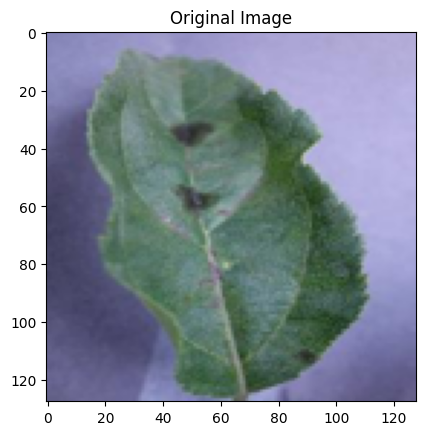

In [ ]:
plt.imshow(data[0])
plt.title('Original Image')
plt.show()

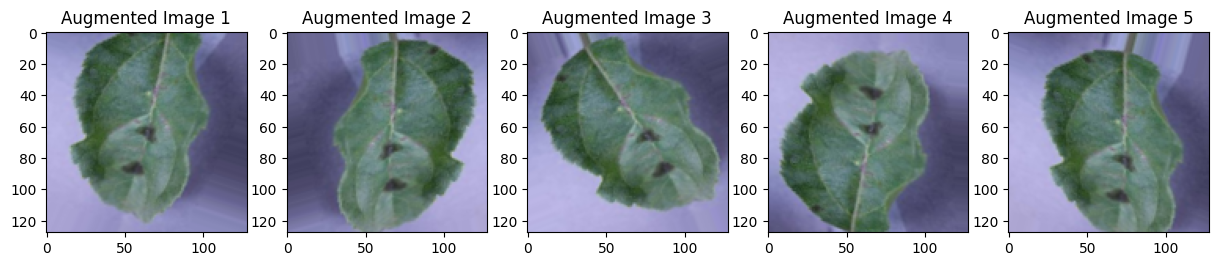

In [ ]:
augment_image(data[0])

In [ ]:
early_stopping = EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

## Deep Learning

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(64, 3, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(0.001),
              metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data = (x_val, y_val),
                    epochs=50,
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/50
79/79 [==============================] - 20s 164ms/step - loss: 1.1138 - accuracy: 0.5236 - val_loss: 0.7827 - val_accuracy: 0.6530
Epoch 2/50
79/79 [==============================] - 12s 155ms/step - loss: 0.7407 - accuracy: 0.6769 - val_loss: 0.6899 - val_accuracy: 0.7508
Epoch 3/50
79/79 [==============================] - 14s 174ms/step - loss: 0.5566 - accuracy: 0.7839 - val_loss: 0.3483 - val_accuracy: 0.8801
Epoch 4/50
79/79 [==============================] - 13s 159ms/step - loss: 0.4083 - accuracy: 0.8423 - val_loss: 0.4634 - val_accuracy: 0.8233
Epoch 5/50
79/79 [==============================] - 14s 174ms/step - loss: 0.3582 - accuracy: 0.8614 - val_loss: 0.2014 - val_accuracy: 0.9243
Epoch 6/50
79/79 [==============================] - 14s 179ms/step - loss: 0.2883 - accuracy: 0.8902 - val_loss: 0.5368 - val_accuracy: 0.8233
Epoch 7/50
79/79 [==============================] - 14s 178ms/step - loss: 0.2811 - accuracy: 0.9018 - val_loss: 0.2076 - val_accuracy: 0.9243

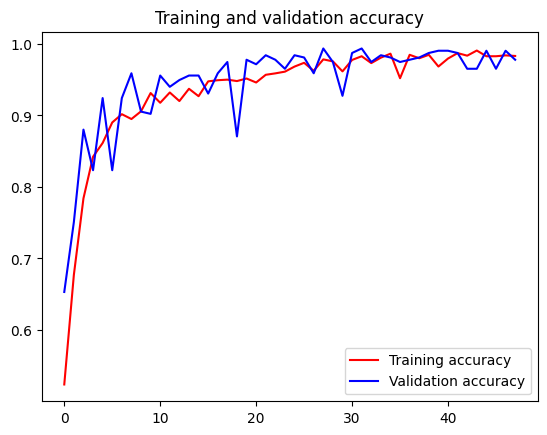

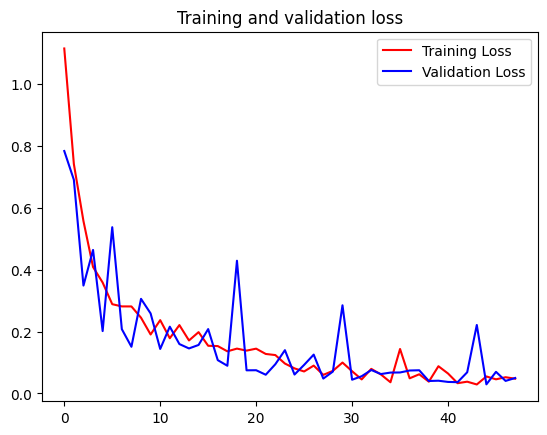

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=class_total))

10/10 [==============================] - 1s 53ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.96      0.91      0.93        55
       Apple___Black_rot       0.99      0.99      0.99        67
Apple___Cedar_apple_rust       1.00      1.00      1.00        26
         Apple___healthy       0.98      0.99      0.99       170

                accuracy                           0.98       318
               macro avg       0.98      0.97      0.98       318
            weighted avg       0.98      0.98      0.98       318



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

print(conf_matrix)

[[ 50   1   0   4]
 [  1  66   0   0]
 [  0   0  26   0]
 [  1   0   0 169]]


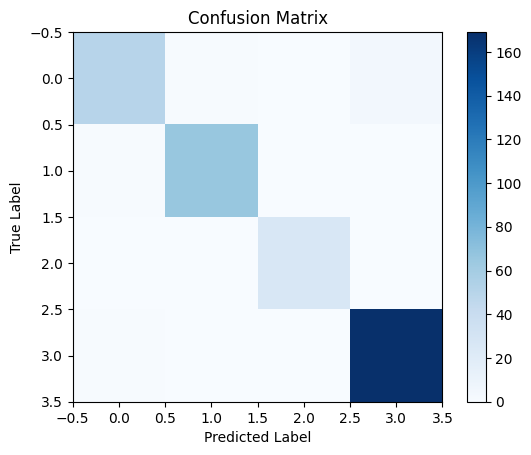

In [ ]:
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Pre trained model using MobileNetV2

In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

def pretrained_model():
    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(0.001),
              metrics=['accuracy'])

    return model

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
pretrained_model = pretrained_model()
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1310784   
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3569028 (13.61 MB)
Trainable params: 1311044 (5.00 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
pretrained_history = pretrained_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data = (x_val, y_val),
                    epochs=50,
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/50
79/79 [==============================] - 20s 202ms/step - loss: 0.7438 - accuracy: 0.8419 - val_loss: 0.1889 - val_accuracy: 0.9432
Epoch 2/50
79/79 [==============================] - 12s 148ms/step - loss: 0.1344 - accuracy: 0.9545 - val_loss: 0.1860 - val_accuracy: 0.9432
Epoch 3/50
79/79 [==============================] - 15s 185ms/step - loss: 0.1184 - accuracy: 0.9645 - val_loss: 0.1555 - val_accuracy: 0.9621
Epoch 4/50
79/79 [==============================] - 12s 157ms/step - loss: 0.1343 - accuracy: 0.9577 - val_loss: 0.1047 - val_accuracy: 0.9779
Epoch 5/50
79/79 [==============================] - 14s 175ms/step - loss: 0.0966 - accuracy: 0.9735 - val_loss: 0.0646 - val_accuracy: 0.9842
Epoch 6/50
79/79 [==============================] - 14s 172ms/step - loss: 0.0646 - accuracy: 0.9772 - val_loss: 0.0958 - val_accuracy: 0.9716
Epoch 7/50
79/79 [==============================] - 14s 173ms/step - loss: 0.0709 - accuracy: 0.9780 - val_loss: 0.0570 - val_accuracy: 0.9811

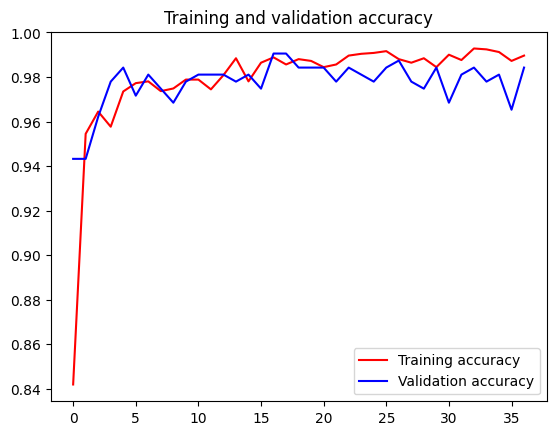

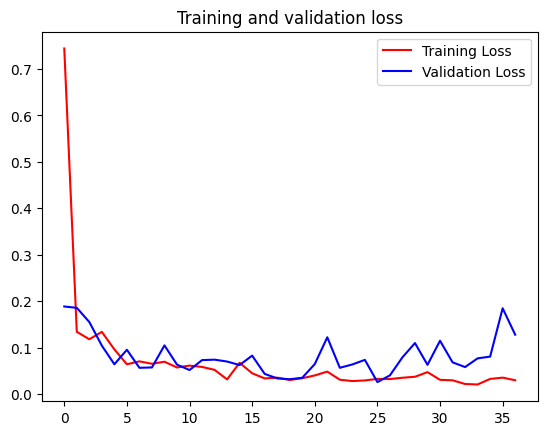

In [ ]:
acc = pretrained_history.history['accuracy']
val_acc = pretrained_history.history['val_accuracy']
loss = pretrained_history.history['loss']
val_loss = pretrained_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = pretrained_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=class_total))

10/10 [==============================] - 2s 101ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.98      0.96      0.97        55
       Apple___Black_rot       1.00      1.00      1.00        67
Apple___Cedar_apple_rust       1.00      1.00      1.00        26
         Apple___healthy       0.99      0.99      0.99       170

                accuracy                           0.99       318
               macro avg       0.99      0.99      0.99       318
            weighted avg       0.99      0.99      0.99       318



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

print(conf_matrix)

[[ 53   0   0   2]
 [  0  67   0   0]
 [  0   0  26   0]
 [  1   0   0 169]]


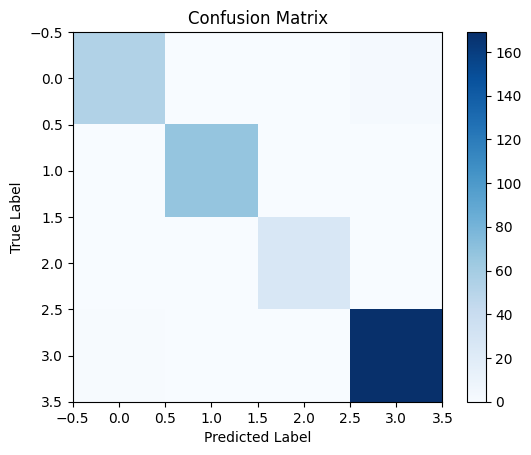

In [ ]:
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## PCA and SVM

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
x_train_new = x_train.reshape((len(x_train), -1))
x_test_new = x_test.reshape((len(x_test), -1))
y_train_new = np.argmax(y_train, axis=1)
y_test_new = np.argmax(y_test, axis=1)
data_new = data.reshape((len(data), -1))

In [ ]:
n_components = 500
pca = PCA(n_components=n_components)
pca.fit_transform(data_new)
X_train_pca = pca.transform(x_train_new)
X_test_pca = pca.transform(x_test_new)

In [ ]:
X_train_pca.shape

(2536, 500)

In [ ]:
X_test_pca.shape

(318, 500)

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(X_train_pca, y_train_new)

SVC()

In [ ]:
y_pred = svm_classifier.predict(X_test_pca)
print(classification_report(y_test_new, y_pred, target_names=class_total))

                          precision    recall  f1-score   support

      Apple___Apple_scab       0.81      0.87      0.84        55
       Apple___Black_rot       0.91      0.90      0.90        67
Apple___Cedar_apple_rust       0.88      0.88      0.88        26
         Apple___healthy       0.96      0.95      0.96       170

                accuracy                           0.92       318
               macro avg       0.89      0.90      0.90       318
            weighted avg       0.92      0.92      0.92       318



In [ ]:
conf_matrix = confusion_matrix(y_test_new, y_pred)

print(conf_matrix)

[[ 48   2   2   3]
 [  5  60   0   2]
 [  1   1  23   1]
 [  5   3   1 161]]


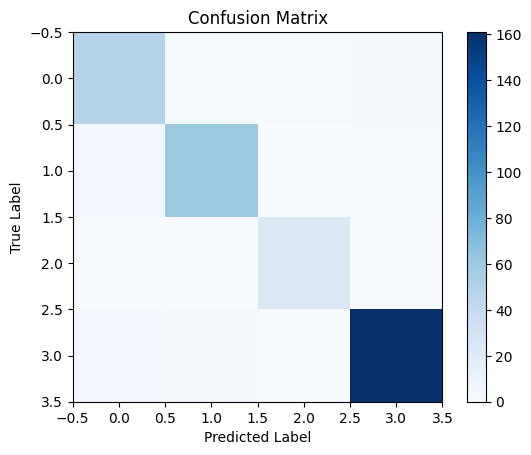

In [ ]:
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()